In [103]:
mapping = {'NORMAL': 0, 'DMV': 1, 'DRUNSEN': 2, 'CNV': 3}
print(f'''
*Modification note here*
{'-' * 40}
The provided dataset was given in folders named NORMAL, DMV, DRUNSEN and CNV. \n
I have converted the naming of these files from NORMAL to 0, DMV to 1, DRUNSEN to 2, CNV to 3. \n
mapping = {mapping} \n
Ruasweatyboi Number 1 !
''')


*Modification note here*
----------------------------------------
The provided dataset was given in folders named NORMAL, DMV, DRUNSEN and CNV. 

I have converted the naming of these files from NORMAL to 0, DMV to 1, DRUNSEN to 2, CNV to 3. 

mapping = {'NORMAL': 0, 'DMV': 1, 'DRUNSEN': 2, 'CNV': 3} 

Ruasweatyboi Number 1 !



In [104]:
from IPython.display import Image
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import time
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Sequential
import os
from datetime import datetime
from packaging import version
import tensorboard

In [105]:
# This section need not be edited (It is intended to setup the working environment for tensorflow)

In [106]:
def config_gpu():
    #Configure Gpus
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [107]:
config_gpu()

In [108]:
image_size = 128
batch_size = 100

In [109]:
#Checkpoint 1: Define Training/Test data size and dimension and explain the rationale for your selection------------------------

In [110]:
print(f'''
For the Training/Test data, I have determined it to be 80% and 20% for the training and test data size respectively as 80% would be sufficient to train the model. \n
For the dimension of the images in the dataset, I have set it to be {image_size} pixels by {image_size} pixels as it has to be sufficiently small enough to run it efficiently. \n
Minimum Height: 496
Maximum Height: 512
Minimum Width: 384
''')


For the Training/Test data, I have determined it to be 80% and 20% for the training and test data size respectively as 80% would be sufficient to train the model. 

For the dimension of the images in the dataset, I have set it to be 128 pixels by 128 pixels as it has to be sufficiently small enough to run it efficiently. 

Minimum Height: 496
Maximum Height: 512
Minimum Width: 384



In [111]:
#Preprocessing Images Functions:

In [112]:
label_str_to_int_mapping = {'NORMAL': 0, 'DME': 1, 'DRUNSEN': 2, 'CNV': 3}

def preprocessing(image, target_size):
    # Extracting labels
    label = tf.strings.split(image, os.sep)[-2]
    label = tf.strings.to_number(label, tf.dtypes.int32)

    # Decoding image file
    path = tf.io.read_file(image)
    image = tf.image.decode_jpeg(path, channels=3)
    
    # Resizing
    image = tf.image.resize(image, [image_size, image_size], preserve_aspect_ratio=False)
    
    # Normalizing
    image = image / 255
    
    return image, label

In [113]:
#Create a tensorflow pipeline and load and preprocess the data

In [114]:
DATA_DIR = '/Users/mongchanghsi/Desktop/SUTD/Term 7/01.116/Healthcare AI Assignment 1/Data'
list_ds = tf.data.Dataset.list_files(DATA_DIR + '/*/*')

dataset_size = len(list_ds)
train_data_size = int(np.floor(0.8 * dataset_size))

preprocess_function = partial(preprocessing, target_size=image_size)
processed_data = list_ds.map(preprocess_function).shuffle(buffer_size=dataset_size,reshuffle_each_iteration=False)
train_data = processed_data.take(train_data_size).batch(batch_size)
test_data = processed_data.skip(train_data_size).batch(batch_size)

In [92]:
#Checkpoint 2: Print a sample of the data and explain the selected range and the purpose of normalisation----------------------

The purpose of normalisation is to ensure that all of the images in the dataset are similar to one another in terms of their individual pixel values as well as their image sizes to avoid any biases in any data and to run the model efficiently


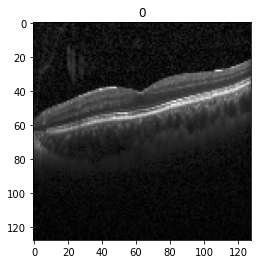

In [93]:
def displayImage(image, label):
    plt.figure()
    plt.title(label.numpy())
    plt.imshow(image)

for image, label in train_data.take(1):
    for i in range(1):
        displayImage(image[i], label[i])

print('The purpose of normalisation is to ensure that all of the images in the dataset are similar to one another in terms of their individual pixel values as well as their image sizes to avoid any biases in any data and to run the model efficiently')

In [44]:
# # Configure dataset for performance
# AUTOTUNE = tf.data.AUTOTUNE

# train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [94]:
#Build Base Model (As defined in the exercise)

In [95]:
model_input = tf.keras.Input(shape=(image_size, image_size, 3), batch_size=batch_size, dtype='float32', name='input')
x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(model_input)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
model_output = tf.keras.layers.Dense(4, name='output')(x)
model = tf.keras.Model(inputs=[model_input], outputs=[model_output])

In [96]:
#Checkpoint 3 Display the graph Print out of the model

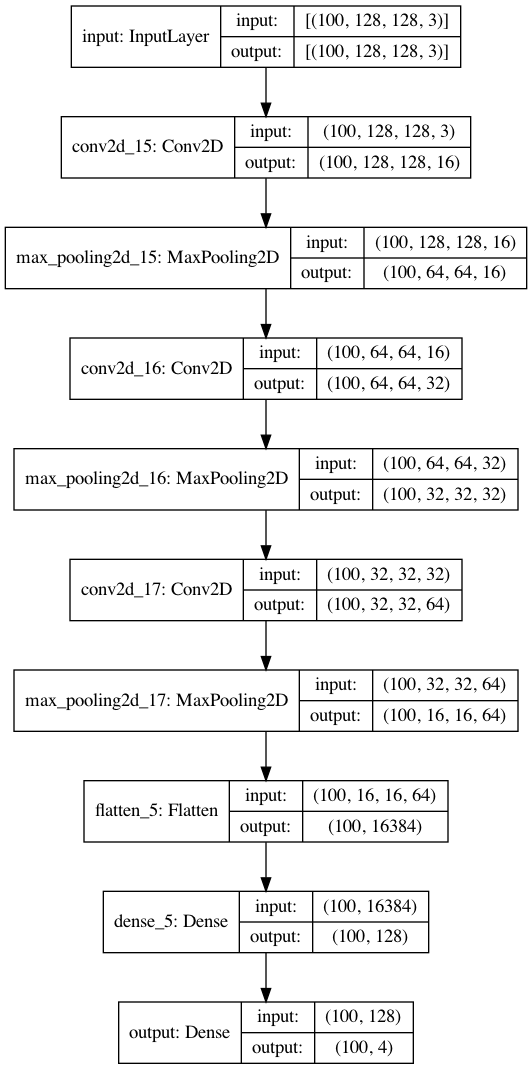

In [97]:
dot_img_file = '/Users/mongchanghsi/Desktop/SUTD/Term 7/01.116/Healthcare AI Assignment 1/model/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, expand_nested=True,show_shapes=True)

In [98]:
# # Settings for Tensorboard
# # %load_ext tensorboard
# %reload_ext tensorboard

# # Define the Keras TensorBoard callback.
# logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = callbacks.TensorBoard(log_dir=logdir)

In [99]:
#Define Loss function and Optimiser
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [100]:
#Checkpoint 4: Explain selection of loss function and optimiser Optimizer

In [101]:
print(f'''
Selection of loss function
{'-' * 40}
Cross entropy are commonly used as loss function when optimizing classification models. \n
Between CategoricalCrossentropy and Binarycrossentropy, we use CategoricalCrossentropy because we are determining what classes are the images under rather than prediction the disease as positive or negative. \n
We use SparseCategoricalCrossentropy because the images should have classes that are mutually exclusive unlike CategoricalCrossentropy which focuses on multiple classes on a single image.
''')
print(f'''
Selection of optimiser
{'-' * 40}
Adaptive Moment Estimation (ADAM) optimizer combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.
''')


Selection of loss function
----------------------------------------
Cross entropy are commonly used as loss function when optimizing classification models. 

Between CategoricalCrossentropy and Binarycrossentropy, we use CategoricalCrossentropy because we are determining what classes are the images under rather than prediction the disease as positive or negative. 

We use SparseCategoricalCrossentropy because the images should have classes that are mutually exclusive unlike CategoricalCrossentropy which focuses on multiple classes on a single image.


Selection of optimiser
----------------------------------------
Adaptive Moment Estimation (ADAM) optimizer combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.



In [53]:
#Define Training/Testing Function here

In [102]:
epochs=10
history = model.fit(
  train_data,
  validation_data=test_data,
  epochs=epochs,
)

print(f'''
Model Summary
{'-' * 40}
''')
model.summary()

Epoch 1/10
80/80 [==============================] - ETA: 0s - loss: 1.3047 - accuracy: 0.3689

KeyboardInterrupt: 

In [87]:
# %tensorboard --logdir logs

In [88]:
#Checkpoint 5: Display training loss-epoch graph

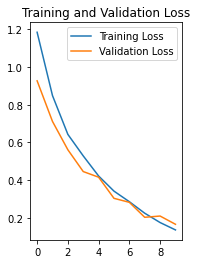

In [188]:
epochs_range = range(epochs)

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [189]:
#Checkpoint 6: Display Accuracy-epoch graph

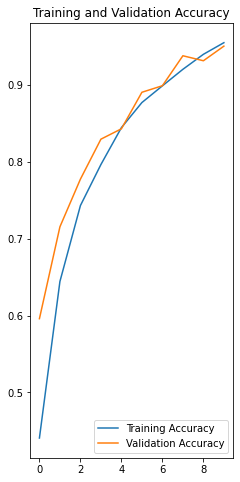

In [190]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

In [191]:
#Checkpoint 7: Define and explain the choice of transfer base model for transfer learning

In [193]:
model_input = tf.keras.Input(shape=(image_size, image_size, 3), batch_size=batch_size, dtype='float32', name='input')

print('''
InceptionV2 is a model that uses several kernel sizes for different type of features.
Larger kernels can be used for more global features that are distributed over a large area of image.
Smaller kernels can be used for a more local, area-specific features.
InceptionV2 is chosen because for a OCT scan, there are many different details that is required to be trained, hence using InceptionV2 as a base model will allow the model to capture different types of features to better classify the images.
''')
# Base Model
# base_model_vgg = tf.keras.applications.VGG19(include_top=False, input_tensor=model_input, input_shape=(image_size,image_size,3), classes=4, classifier_activation='relu')
# base_model_resnet = tf.keras.applications.ResNet50(include_top=False, input_tensor=model_input, input_shape=(image_size,image_size,3), classes=4)
base_model_inception = tf.keras.applications.InceptionResNetV2(include_top=False, input_tensor=model_input, input_shape=(image_size,image_size,3), classes=4, classifier_activation='relu')

chosen_model = base_model_inception
# Extension
chosen_model.trainable = False

x = chosen_model(model_input, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
model_output = tf.keras.layers.Dense(4, name='output')(x)
model = tf.keras.Model(inputs=[model_input], outputs=[model_output])


InceptionV2 is a model that uses several kernel sizes for different type of features.
Larger kernels can be used for more global features that are distributed over a large area of image.
Smaller kernels can be used for a more local, area-specific features.
InceptionV2 is chosen because for a OCT scan, there are many different details that is required to be trained, hence using InceptionV2 as a base model will allow the model to capture different types of features to better classify the images.



In [ ]:
#Checkpoint 8: Display graph printout of the base model with the OCT image classication extension

In [ ]:
transfermodel_img_file = '/Users/mongchanghsi/Desktop/SUTD/Term 7/01.116/Healthcare AI Assignment 1/model/model_2.png'
tf.keras.utils.plot_model(model, to_file=transfermodel_img_file, expand_nested=True,show_shapes=True)

In [ ]:
#Run the new model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=10
history2 = model.fit(
  train_data,
  validation_data=test_data,
  batch_size=batch_size,
  epochs=epochs,
)

model.summary()

In [ ]:
#Checkpoint 9: The training data currently being used is simple and as such transfer learning isn't as advantageous,
#however some observations can be made when comparing the first model with the second, discuss these observation.

In [194]:
print('''
After running both model, the accuracy for the second mode, despite taking a much longer duration to run (due to the several times more layers in InceptionV2), is lower than the accuracy for model 1.
The parameters trained in both model are greatly different as the 1st model only has 2,121,380 trainable parameters while the 2nd model has 787,076. With a lower trainable parameters would means that the weights for 2nd model is not as adjusted to the images as compared to the 1st model.
''')


After running both model, the accuracy for the second mode, despite taking a much longer duration to run (due to the several times more layers in InceptionV2), is lower than the accuracy for model 1.
The parameters trained in both model are greatly different as the 1st model only has 2,121,380 trainable parameters while the 2nd model has 787,076. With a lower trainable parameters would means that the weights for 2nd model is not as adjusted to the images as compared to the 1st model.



In [195]:
#Checkpoint 10: Discuss why this may not be favourable and the problems it presents. 

In [196]:
print('''
With lesser data under CNV, the model will be skewed and affect the weights of the model.
This will lead to model being overfitting the training data as there isn't much information to capture the important features.
This would lead to a underperformance for classifying CNV images.
''')


With lesser data under CNV, the model will be skewed and affect the weights of the model.
This will lead to model being overfitting the training data as there isn't much information to capture the important features.
This would lead to a underperformance for classifying CNV images.



In [21]:
#Checkpoint 11: Show some methods that can be utilised to negate or minimise these effects. 
#Compare the accuracy and explain the pros and cons of these techniques (If any) 

In [22]:
print(f'''
There are few ways to improve the model.
1) Increase the amount of training data through normal collection methods (such as taking more CNV-classed images)
2) Increase the amount of training data through Data Augmentation (Rotating/Scaling/Zoom/Brightness/Color Shift)
3) Produce synthetic data
4) Increase the number of passes on the existing training data
5) Transfer Learning

In the following code, I will be using Data Augmentation and do simple rotating on every image of CNV to produce additional images.
''')


There are few ways to improve the model.
1) Increase the amount of training data through normal collection methods (such as taking more CNV-classed images)
2) Increase the amount of training data through Data Augmentation (Rotating/Scaling/Zoom/Brightness/Color Shift)
3) Produce synthetic data
4) Increase the number of passes on the existing training data
5) Transfer Learning

In the following code, I will be using Data Augmentation and do simple rotating on every image of CNV to produce additional images.



In [118]:
# Preprocessing / Data Augmentation CNV Images
CNV_ds = tf.data.Dataset.list_files(DATA_DIR + '/3/*')
processed_CNV_ds = CNV_ds.map(preprocess_function)

for image, label in processed_CNV_ds:
#     plt.figure()
#     plt.imshow(image)
    
    imageShape = image.shape
    imageType = image.dtype
    for i in range(1):
#         image = tf.keras.preprocessing.image.random_rotation(image, 180)
        image = tf.image.random_flip_left_right(image, 5)
        image = tf.image.random_flip_up_down(image, 5)
#         plt.figure()
#         plt.imshow(image)
        imageDS = tf.data.Dataset.from_tensors(image)
        imageLabel = tf.data.Dataset.from_tensors(label)
        newData = tf.data.Dataset.zip((imageDS, imageLabel))
        processed_CNV_ds = processed_CNV_ds.concatenate(newData)

NORMAL_ds = tf.data.Dataset.list_files(DATA_DIR + '/0/*')
DMV_ds = tf.data.Dataset.list_files(DATA_DIR + '/1/*')
DRUNSEN_ds = tf.data.Dataset.list_files(DATA_DIR + '/2/*')
newDS = NORMAL_ds.concatenate(DMV_ds).concatenate(DRUNSEN_ds)

# The 3 unbiased classes undergo preprocessing
processed_other_classes_ds = newDS.map(preprocess_function)

# Concatenating the 3 classes with the CNV
new_preprocessed_ds = processed_other_classes_ds.concatenate(processed_CNV_ds)

# Shuffling the data
new_dataset_size = len(new_preprocessed_ds)
new_preprocessed_ds = new_preprocessed_ds.shuffle(new_dataset_size, reshuffle_each_iteration=False)
# for image, label in new_preprocessed_ds.take(20):
#     print(label)
    
# Batching
new_train_data_size = int(np.floor(0.8 * new_dataset_size))
new_train_data = new_preprocessed_ds.take(new_train_data_size).batch(batch_size)
new_test_data = new_preprocessed_ds.skip(new_train_data_size).batch(batch_size)

In [ ]:
new_model_input = tf.keras.Input(shape=(image_size, image_size, 3), batch_size=batch_size, dtype='float32', name='new_input')
x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(new_model_input)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
new_model_output = tf.keras.layers.Dense(4, name='new_output')(x)
new_model = tf.keras.Model(inputs=[new_model_input], outputs=[new_model_output])

# new_model.summary()

new_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=10
history3 = new_model.fit(
  new_train_data,
  validation_data=new_test_data,
  epochs=epochs
)

Epoch 1/10


In [ ]:
# Pros of synthetic data: No risk of copyright issues; Perfect for understanding a particular concept
# Cons of synthetic data: Risk of introducing biases; Issues iwth understanding real-world data problems

# Cons of transfer learning: Features learnt by previous model may not be of any relevance to the training dataset and may cause bad predictions instead.